In [17]:
import numpy  as np
import json
import matplotlib.pylab as plt
import copy
import cv2
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from tqdm import tqdm
import torch
from collections import OrderedDict
from pathlib import Path
import random

In [32]:
damage = 'origin_crack'
path = Path('/mmdetection/data/merimen_coco/06_04_2022/'+damage)
data = json.load(open(path/'annotations'/'total.json'))
print(len(data['images']),len(data['annotations']))

98603 160079


In [11]:
cp = json.load(open('/mmdetection/data/carpart/annotations/test.json'))
#print(cp['categories'])

In [21]:
if damage == 'dent':
    #config_file = '../configs/detectors/dent_detector_latest_segm.py'
    #checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'
    config_file = '../models/cbnet/dent_pseudo/dent_pseudo.py'
    checkpoint_file = '../models/cbnet/dent_pseudo/epoch_30.pth'

if damage == 'loose':
    config_file = '../models/loose/loose.py'
    checkpoint_file = '../models/loose/epoch_9.pth'

if damage == 'crack':
    config_file = '../models/crack_mosaic/crack_mosaic.py'
    checkpoint_file = '../models/crack_mosaic/epoch_7.pth'

if damage == 'scratch':
    config_file = '../models/scratch_pseudo_brightness/scratch_pseudo.py'
    checkpoint_file = '../models/scratch_pseudo_brightness/epoch_9.pth'
    #config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
    #checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'
if damage == 'combine_missing':
    config_file = '../work_dirs/missing/missing.py'
    checkpoint_file = '../work_dirs/missing/epoch_10.pth'
    
#if damage == 'carpart':
#config_file = '../checkpoints/carpart_rear_exp_2/carpart_rear.py'
#checkpoint_file = '../checkpoints/carpart_rear_exp_2/epoch_29.pth'

config_file = '../configs/cbnet/mask_rcnn_cbv2_swin_tiny_patch4_window7_mstrain_480-800_adamw_3x_coco.py'
checkpoint_file = '../pretrain/mask_rcnn_cbv2_swin_tiny_patch4_window7_mstrain_480-800_adamw_3x_coco.pth'

In [22]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [13]:
CATEGORIES = [c['name'] for c in cp['categories']]
#highlight = ['rbu_rear_bumper', 'tail_gate', 'tli_tail_light', 'qpa_quarter_panel' , 'rwi_rear_windshield','blp_back_license_plate']
#code = [CATEGORIES.index(h)-1 for h in highlight]
#code = set(code)
#print(code)

In [15]:
rear_images = []
for img in tqdm(cp['images']):
    cates = [a['category_id'] for a in cp['annotations'] if a['image_id']==img['id']]
    overlap = code.intersection(cates)
    if len(overlap) / len(code) >= 0.5 and len(cates) <= 5:
        rear_images.append(img['id'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [00:01<00:00, 652.46it/s]


[0.9976059 0.9944693]
['tyre', 'fbu_front_bumper']
[[(834, 8), (1020, 348)], [(0, 0), (993, 402)]]


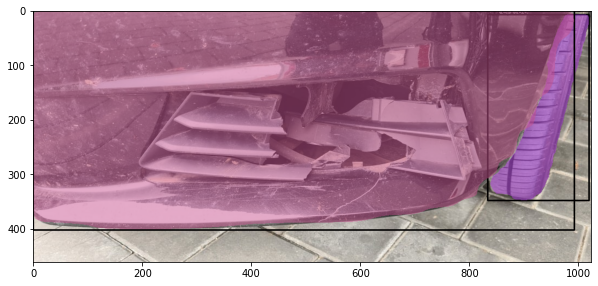

In [16]:
img = cv2.imread('test.jpg')
#print(test['images'][1])
h,w,_ = img.shape
#img = img[:int(h/2),:int(w/2)]
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.7)
#img_ = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
print(scores)

print([CATEGORIES[l+1] for l in pred_labels])
plt.figure(figsize=(10,10))
plt.imshow(img_)
print(pred_boxes)

In [6]:
def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    #print(box1,box2)
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

In [22]:
pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = 0
num_tp = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.75)
    #print(pred_labels)
    overlap = code.intersection(pred_labels)
    
    if len(overlap) / len(code) < 0.5:
        continue
    
    pseudo_segms = pred_segms

    if len(pseudo_segms) == 0:
        continue
        
    pseudo_data['images'].append(img)
    
    for iteration,segm in enumerate(pseudo_segms):
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = img['id']
            annotation['category_id'] = int(pred_labels[iteration]+1)
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            pseudo_data['annotations'].append(annotation)
pseudo_data['categories'] = cp['categories']
    
with open(path/'annotations'/'post_pseudo_carparts_rear.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

  0%|                                                                                                                                                           | 0/13658 [00:00<?, ?it/s]/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13658/13658 [35:30<00:00,  6.41it/s]


In [11]:
cp_info = OrderedDict()
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.75)
    cp_info[img['file_name']] = len(pred_boxes)
with open(damage+'_carpart_num.json', 'w', encoding='utf-8') as f:
    json.dump(cp_info, f, ensure_ascii=False, indent=4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3775/3775 [24:08<00:00,  2.61it/s]


In [7]:
#pseudo_data = json.load(open(path/'annotations'/'post_pseudo_carparts_rear.json'))
#print(len(pseudo_data['images']),len(pseudo_data['annotations']))
data['images'][0]

{'id': 55928,
 'license': 4,
 'coco_url': 'coco.org',
 'flickr_url': 'flickr.org',
 'task_name': 'nothing',
 'url': 'https://mc-vip.s3-ap-southeast-1.amazonaws.com/antn_mrm/batch_02/Vendor_Ext/9661976/0979A08B-E7F2-B1BF-ABBB592B4AEAFCFC.JPG',
 'width': 640,
 'height': 480,
 'file_name': 'https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9661976_0979A08B-E7F2-B1BF-ABBB592B4AEAFCFC.JPG',
 'date_captured': '2013-12-15 02:41:52'}

In [28]:
def sample(js_data):
    #i = random.choice(js_data['images'])
    num = 3
    imgs = random.sample(js_data['images'],num**2)
    #print(i['id'],i['url'])
    #num = 2 
    fig, axis = plt.subplots(num, num,figsize=(15,15))
    
    for idx,i in enumerate(imgs):
        annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) 
                 for a in js_data['annotations'] if a['image_id'] == i['id']]
        image = cv2.imread(str(path/'images'/i['file_name']))
        image = cv2.drawContours(image,annos,-1,(255,0,0),2)
        
        axis[int(idx/num),idx%num].imshow(image)
        axis[int(idx/num),idx%num].set_title(i['id'])
        
    #plt.figure(figsize=(20,10))
    #plt.imshow(image)

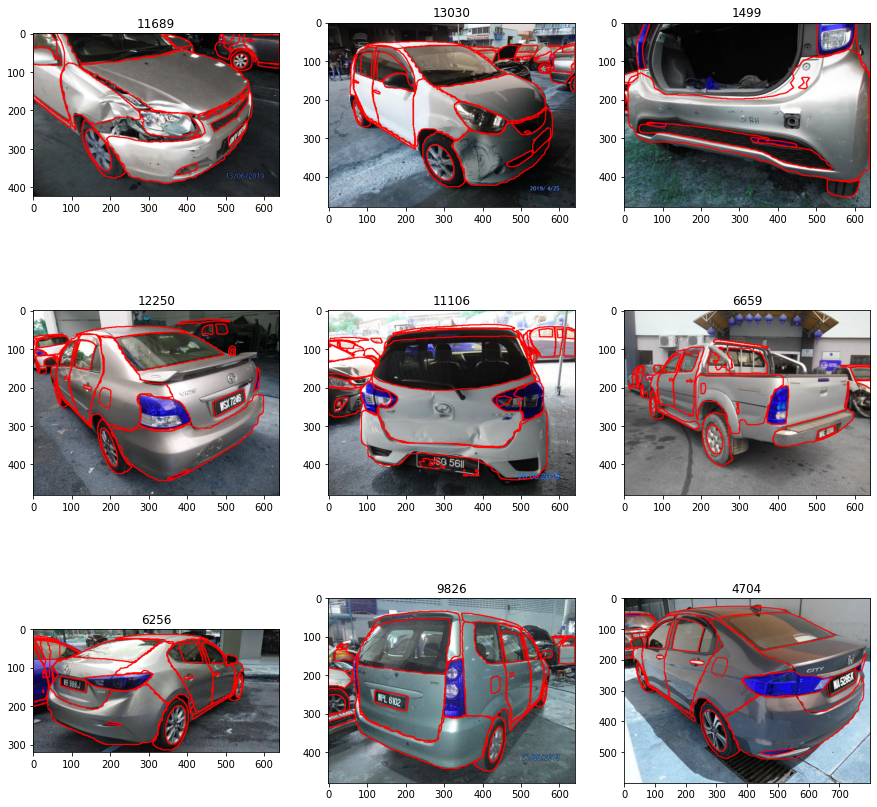

In [26]:
sample(pseudo_data)

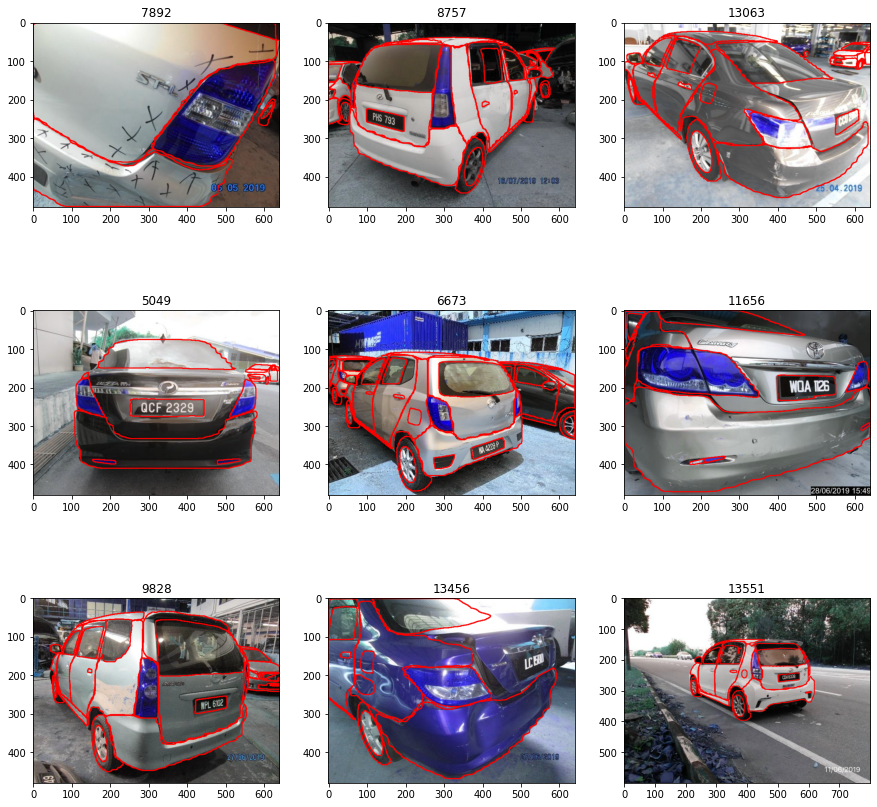

In [28]:
sample(pseudo_data)

In [65]:
dent : 5559/8458

0.657247576259163

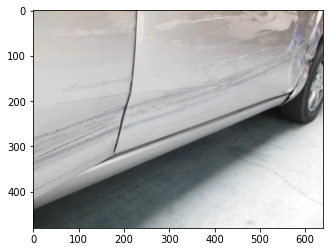

In [8]:
img_data = data['images'][0]
image = cv2.imread(str(path/'images'/img_data['file_name']))
plt.imshow(image)

In [12]:
pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []
pseudo_data['categories'] = cp['categories']

#image_id = 0
num_img = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.75)
    #print(pred_labels)
    if len(pred_boxes) < 20 : 
        pseudo_data['images'].append(img)
        num_img += 1
        
    if num_img % 2500 == 0 :
        with open(path/'annotations'/str('pre_annotation_cp_'+str(num_img)+'_.json'), 'w', encoding='utf-8') as f:
            json.dump(pseudo_data, f, ensure_ascii=False, indent=4)
        
with open(path/'annotations'/'pre_annotation_cp.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90298/90298 [3:30:57<00:00,  7.13it/s]


In [54]:
path = Path('/mmdetection/data/scratch/')
data = json.load(open(path/'annotations'/'train.json'))
print(len(data['images']))

16144


[0.7318534] [7]


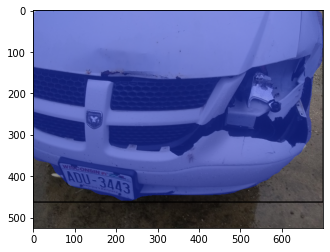

In [20]:
image = cv2.imread(str(path/'images'/data['images'][0]['file_name']))
result = inference_detector(model, image)
img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.5)
print(pred_scores,pred_labels)
plt.imshow(img_)

In [21]:
data['categories']

[{'supercategory': 'Carparts', 'id': 0, 'name': 'scratch'}]

In [33]:
out_data = copy.deepcopy(data)
out_data['annotations'] = []
annotation_id = 0
out_data['categories'] = [{'supercategory': 'Car', 'id': 0, 'name': 'car'}]
for i in tqdm(data['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.55)
    
    if len(pred_boxes) == 0:
        continue
        
    for idx,segm in enumerate(pred_segms):
        if pred_labels[idx] not in [2,7]:
            continue
        
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = i['id']
            annotation['category_id'] = 0
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            out_data['annotations'].append(annotation)
with open(path/'annotations'/'total_car.json', 'w', encoding='utf-8') as f:
    json.dump(out_data, f, ensure_ascii=False, indent=4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98603/98603 [3:37:01<00:00,  7.57it/s]


In [36]:
t = json.load(open('car.json'))


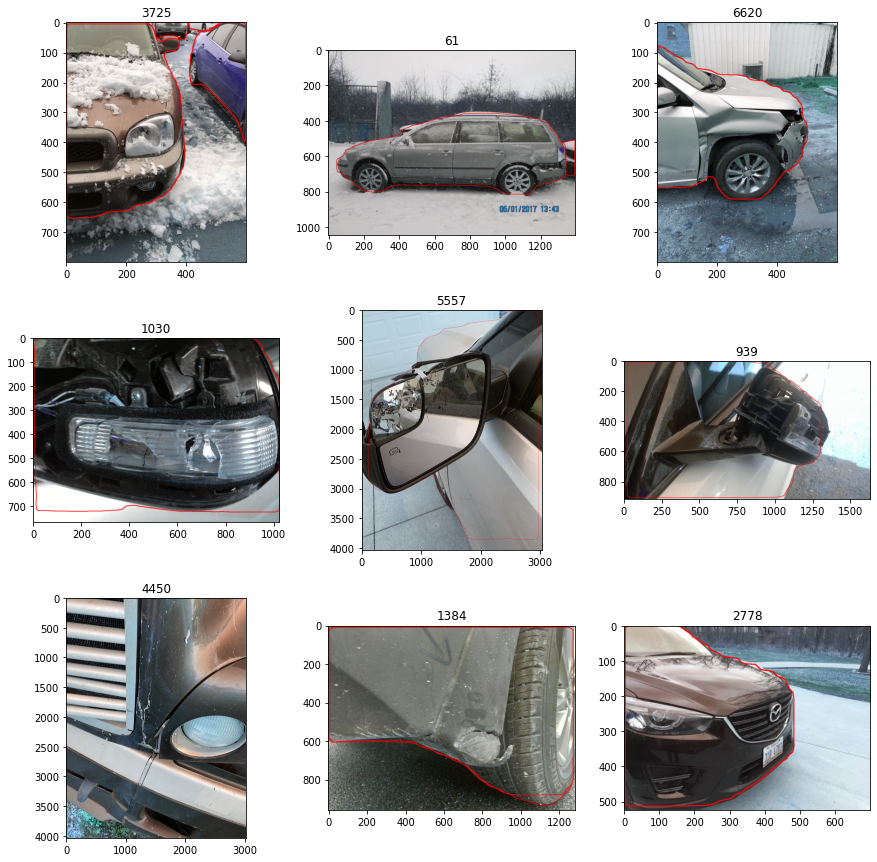

In [31]:
sample(out_data)